In [1]:
import os

from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.tools import tool

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [2]:
model = ChatGroq(model="deepseek-r1-distill-llama-70b",
                   temperature=0.1,
                   max_tokens=500)

model.invoke("Latentview analytics").content

'<think>\n\n</think>\n\nLatentView Analytics is a leading analytics and business intelligence firm that specializes in helping organizations leverage data to make informed decisions. The company provides a range of services, including data analytics, business intelligence, predictive analytics, and big data solutions. Here are some key aspects of LatentView Analytics:\n\n1. **Data Analytics**: LatentView helps organizations analyze and interpret complex data sets to uncover insights that can drive business performance. This includes descriptive, diagnostic, predictive, and prescriptive analytics.\n\n2. **Business Intelligence**: The company offers business intelligence solutions that enable organizations to make data-driven decisions. This includes developing BI dashboards, reports, and KPIs to monitor business performance.\n\n3. **Predictive Analytics**: LatentView uses advanced statistical techniques and machine learning algorithms to predict future trends and behaviors. This helps o

In [3]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [4]:
@tool
def multiply(x:int, y:int) -> int:
    """Multiply two integers together."""
    return x * y

In [9]:
multiply({"x":2,"y":5})

10

In [10]:
@tool
def search(query:str) -> str:
    """Search the web for a query."""
    tavily = TavilySearchResults()
    result = tavily.invoke({"query":query})
    return f"Result for {query} is : \n{result}"

In [17]:
print(search("India vs england first test hadingly"))

Result for India vs england first test hadingly is : 
[{'title': 'Live Cricket Update - ENG vs IND 1st Test - ESPNcricinfo', 'url': 'https://www.espncricinfo.com/series/india-in-england-2025-1445348/england-vs-india-1st-test-1448349/live-match-blog', 'content': 'England will need 371 to win the first Test at Headingley, after India were dismissed for 364 in their second innings late on day four. They will return on Tuesday needing 350 more, after Zak Crawley and Ben Duckett negotiated the first six overs of the chase without alarm to close on 21 for 0. [...] Yashasvi Jaiswal’s sparkling hundred put India in charge of the first Test at Headingley. Jaiswal became the first Indian batter to score centuries in his first match in both Australia and England, and his innings was a masterclass in off-side strokeplay: only nine of his first 100 runs came on the leg side, and he cut and drove England’s seamers into submission. [...] _England won the toss and chose to bowl first vs India_\n\nB Sa

In [18]:
tools = [multiply, search]

llm_with_tools = model.bind_tools(tools)

In [20]:
result = llm_with_tools.invoke("What is the result of pro kabbadi league 2024")

In [21]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'Pro Kabaddi League 2024 result'},
  'id': 'awsb1dxas',
  'type': 'tool_call'}]

In [22]:
tool_mapping = { tool.name: tool for tool in tools}
tool_mapping

{'multiply': StructuredTool(name='multiply', description='Multiply two integers together.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001F1D2378FE0>),
 'search': StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001F1D301BEC0>)}

In [23]:
tool_mapping[result.tool_calls[0]["name"]].invoke(result.tool_calls[0]["args"])

'Result for Pro Kabaddi League 2024 result is : \n[{\'title\': \'Pro Kabaddi Points Table 2024 - News18\', \'url\': \'https://www.news18.com/pro-kabaddi/table/\', \'content\': "| Teams | P | W | L | T | Score Diff | PTS |\\n| --- | --- | --- | --- | --- | --- | --- |\\n| Haryana Steelers | 22 | 16 | 6 | 0 | 112 | 84 |\\n| Dabang Delhi K.C. | 22 | 13 | 5 | 4 | 85 | 81 |\\n| UP Yoddhas | 22 | 13 | 6 | 3 | 97 | 79 |\\n| Patna Pirates | 22 | 13 | 7 | 2 | 93 | 77 |\\n| U Mumba | 22 | 12 | 8 | 2 | 16 | 71 |\\n| Jaipur Pink Panthers | 22 | 12 | 8 | 2 | 55 | 70 |\\n| Telugu Titans | 22 | 12 | 10 | 0 | -40 | 66 |\\n| Puneri Paltan | 22 | 9 | 10 | 3 | 61 | 60 | [...] | Tamil Thalaivas | 22 | 8 | 13 | 1 | 16 | 50 |\\n| Bengal Warriorz | 22 | 5 | 14 | 3 | -116 | 41 |\\n| Gujarat Giants | 22 | 5 | 14 | 3 | -152 | 38 |\\n| Bengaluru Bulls | 22 | 2 | 19 | 1 | -227 | 19 | [...] Patna Pirates top the overall points charts in the PKL with 6688 points to their name, while Bengaluru Bulls with 6407 points

In [39]:
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage

In [40]:
class AgentState(TypedDict):
    """Agent state"""
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [41]:
def invoke_model(state:AgentState):
    messages=state["messages"]
    question=messages[-1]
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}

In [42]:
def router(state:AgentState):
    tool_calls=state["messages"][-1].tool_calls
    if len(tool_calls)>0:
        return "tool"
    else:
        return "end"

In [43]:
def invoke_tool(state:AgentState):
    tool_details=state["messages"][-1].tool_calls
    
    if tool_details is None:
        return Exception("No tool calls found in the last message.")
    
    print(f"Seleted tool: {tool_details[0]['name']}")
    
    if tool_details[0]["name"]=="search":
        response=input(prompt=f"[yes/no] do you want to continue with this expensive web search")
        if response.lower()=="no":
            print("web search discarded by the user. exiting gracefully")
            raise Exception("Web search discarded by the user.")
            
    
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])
    return {"messages":[response]}

In [44]:

from langgraph.graph import StateGraph, START,END


graph=StateGraph(AgentState)

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)


graph.add_conditional_edges("ai_assistant",
                            router,
                            {
                                "tool":"tool",
                                "end":END
                            }
                            )


graph.add_edge("tool", END)

In [45]:

graph.set_entry_point("ai_assistant")

In [46]:
app=graph.compile()

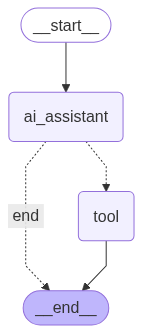

In [47]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [48]:
app.invoke({"messages":["What is the current gdp of the india?"]})

Seleted tool: search
web search discarded by the user. exiting gracefully


Exception: Web search discarded by the user.